In [1]:
using Pkg 
Pkg.activate("..")

  Activating project at `~/code/PhasorNetworks.jl`


In [2]:
include("../src/PhasorNetworks.jl")
using .PhasorNetworks, Plots, DifferentialEquations

In [3]:
using Lux, MLUtils, MLDatasets, OneHotArrays, Statistics, Test, LuxCUDA
using Random: Xoshiro, AbstractRNG
using Base: @kwdef
using Zygote: withgradient
using Optimisers, ComponentArrays
using Statistics: mean
using LinearAlgebra: diag
using PhasorNetworks: bind
using Distributions: Normal
using DifferentialEquations: Heun, Tsit5

[ Info: Waiting for another process (pid: 3507027) to finish precompiling PhasorNetworks [c32d742c-e486-48f1-8804-9f6fb4d3f42c]. Pidfile: /home/wolinammentorp/.julia/compiled/v1.11/PhasorNetworks/JvTJG_OGjUn.ji.pidfile


In [4]:
solver_args = Dict(:adaptive => false, :dt => 0.01)

spk_args = SpikingArgs(threshold = 0.001,
                    solver=Tsit5(), 
                    solver_args = solver_args)

Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 0.001 (V)


In [5]:
cdev = cpu_device()
gdev = gpu_device()

(::CUDADevice{Nothing, Missing}) (generic function with 1 method)

In [6]:
#global args for all tests
n_x = 101
n_y = 101
n_vsa = 1
epsilon = 0.10
repeats = 10
epsilon = 0.025


tspan = (0.0, repeats*1.0)
tbase = collect(tspan[1]:spk_args.solver_args[:dt]:tspan[2])

@kwdef mutable struct Args
    η::Float64 = 3e-4       ## learning rate
    batchsize::Int = 256    ## batch size
    epochs::Int = 10        ## number of epochs
    use_cuda::Bool = false   ## use gpu (if cuda available)
    rng::Xoshiro = Xoshiro(42) ## global rng
end

Args

In [7]:
c_args = Args(use_cuda = false)
g_args = Args(use_cuda = true)

Args(0.0003, 256, 10, true, Xoshiro(0xa379de7eeeb2a4e8, 0x953dccb6b532b3af, 0xf597b8ff8cfd652a, 0xccd7337c571680d1, 0xc90c4a0730db3f7e))

# Static

In [30]:
x_in = random_symbols((64, 64, 1, 4), c_args.rng)

64×64×1×4 Array{Float32, 4}:
[:, :, 1, 1] =
  0.738943  -0.661291   0.383229   …  -0.131916   -0.731652    0.405777
  0.106315  -0.532118   0.211457      -0.809023   -0.976191   -0.640921
 -0.144237  -0.215981   0.636316      -0.743837    0.925919    0.87413
  0.649252  -0.38936    0.632936      -0.379693   -0.763081   -0.0706105
  0.509333   0.278375  -0.766068       0.694137   -0.968576   -0.73509
 -0.370936   0.647599  -0.617368   …  -0.895247    0.479281   -0.533071
  0.10158   -0.263718   0.421316       0.715106    0.48404    -0.819042
  0.837065  -0.74337   -0.999988      -0.723698    0.968253   -0.605683
 -0.59385   -0.308261   0.628449       0.0768831  -0.404148   -0.672466
  0.465014  -0.593555  -0.971774      -0.311067    0.252026   -0.953807
 -0.319144   0.271559   0.298807   …   0.691992   -0.728295    0.669838
 -0.287392  -0.246906  -0.837627      -0.935137    0.633569    0.840586
 -0.941859  -0.731669   0.458878       0.992881   -0.282574   -0.171229
  ⋮                  

In [31]:
layer = Chain(PhasorConv((32, 32), 1 => 1, complex_to_angle, init_bias=default_bias),)

Chain(
    layer_1 = PhasorConv(
        layer = Conv((32, 32), 1 => 1, use_bias=false),  # 1_024 parameters
        bias = ComplexBias((1, 1, 1)),            # 2 parameters
    ),
)         # Total: 1_026 parameters,
          #        plus 0 states.

In [32]:
sol_layer = Chain(PhasorConv((32, 32), 1 => 1, complex_to_angle, return_solution=true),)

Chain(
    layer_1 = PhasorConv(
        layer = Conv((32, 32), 1 => 1, use_bias=false),  # 1_024 parameters
        bias = ComplexBias((1, 1, 1)),            # 2 parameters
    ),
)         # Total: 1_026 parameters,
          #        plus 0 states.

In [33]:
ps, st = Lux.setup(c_args.rng, layer)

((layer_1 = (layer = (weight = Float32[0.011874189 0.03953247 … -0.0049358797 0.04566341; -0.0023277262 -0.00025779888 … -0.03007738 -0.02774524; … ; 0.02032557 -0.04452908 … -0.030348007 -0.006028986; 0.020747421 -0.016390469 … -0.040847726 -0.04960784;;;;],), bias = (bias_real = Float32[1.0;;;], bias_imag = Float32[0.0;;;])),), (layer_1 = (layer = NamedTuple(), bias = NamedTuple()),))

In [34]:
function zero_weights(nt::NamedTuple)
    return NamedTuple{keys(nt)}(map(zero_weights, values(nt)))
end

function zero_weights(x::AbstractArray)
    return x
end

function zero_weights(x)
    return x
end

function zero_weights(nt::NamedTuple{(:bias_real,)})
    return (bias_real = zeros(size(nt.bias_real)),)
end

function zero_weights(nt::NamedTuple{(:bias_imag,)})
    return (bias_imag = zeros(size(nt.bias_imag)),)
end

function zero_weights(nt::NamedTuple{names}) where names
    new_nt = nt
    if :bias_real in names
        new_nt = merge(new_nt, (bias_real = zeros(size(nt.bias_real)),))
    end
    if :bias_imag in names
        new_nt = merge(new_nt, (bias_imag = zeros(size(nt.bias_imag)),))
    end
    if new_nt === nt
        return NamedTuple{names}(map(zero_weights, values(nt)))
    else
        return new_nt
    end
end


zero_weights (generic function with 5 methods)

In [35]:
ps_nb = zero_weights(ps)

(layer_1 = (layer = (weight = Float32[0.011874189 0.03953247 … -0.0049358797 0.04566341; -0.0023277262 -0.00025779888 … -0.03007738 -0.02774524; … ; 0.02032557 -0.04452908 … -0.030348007 -0.006028986; 0.020747421 -0.016390469 … -0.040847726 -0.04960784;;;;],), bias = (bias_real = [0.0;;;], bias_imag = [0.0;;;])),)

In [36]:
y, _ = layer(x_in, ps, st)

(Float32[0.31375194 0.18704154 … 0.24516785 0.35924205; -0.046223108 0.088617235 … -0.27460134 -0.2080928; … ; 0.037995417 0.3166146 … -0.0016903714 -0.08883521; -0.28843158 -0.15649094 … 0.3513328 0.18412171;;;; -0.11937584 0.03317227 … 0.2411234 -0.12388989; 0.37832946 0.15144043 … -0.14273146 0.18361486; … ; 0.05622811 -0.09787742 … -0.44700795 0.041512493; -0.04802505 0.25883138 … 0.3146254 0.053686183;;;; 0.060926758 -0.14038423 … -0.02993276 -0.016993305; -0.19488893 -0.08126304 … 0.065542676 -0.11631095; … ; 0.3358438 -0.17153603 … -0.21859008 0.32262352; 0.033751845 -0.044332772 … -0.40022296 -0.11598137;;;; 0.09923544 0.03632612 … -0.100315526 0.1652009; 0.12706986 0.19989225 … 0.12283483 -0.17459972; … ; 0.09973372 -0.11491481 … -0.37292004 0.19190896; 0.024222422 -0.054468922 … 0.06605046 -0.054979973], (layer_1 = (layer = NamedTuple(), bias = NamedTuple()),))

In [37]:
yu, _ = layer(x_in, ps_nb, st)

([0.4725339997103302 0.44738653327878064 … 0.7161351973263002 0.6574895779200325; -0.32317670764524664 0.1966553470742538 … -0.4165453491721344 -0.5103089247821972; … ; 0.42582630424098333 0.941122621818288 … -0.9988687354660265 -0.7846120799430649; -0.4993683569086384 -0.35935080491646637 … 0.6615844778354566 0.48517289010278064;;;; -0.6728000550131127 0.21825758880296794 … 0.7912856842319452 -0.213579803237124; 0.5620864271638365 0.2766126069461672 … -0.8139923136771431 0.8345394607832883; … ; 0.48078673915486875 -0.6680151303086025 … -0.9624865573582609 0.10338635130564405; -0.7353525520197205 0.8892446854026516 … 0.44456436917353914 0.09769828682981703;;;; 0.1250778879385603 -0.6922086062165403 … -0.06372014495679684 -0.037600388524652924; -0.39358974056887125 -0.27698937305492904 … 0.16543800188124025 -0.3206907456271663; … ; 0.5775584977235512 -0.33841513099450604 … -0.3452872339049403 0.738234397105147; 0.06053008433543802 -0.0822553505199275 … -0.554943694783953 -0.270157338535

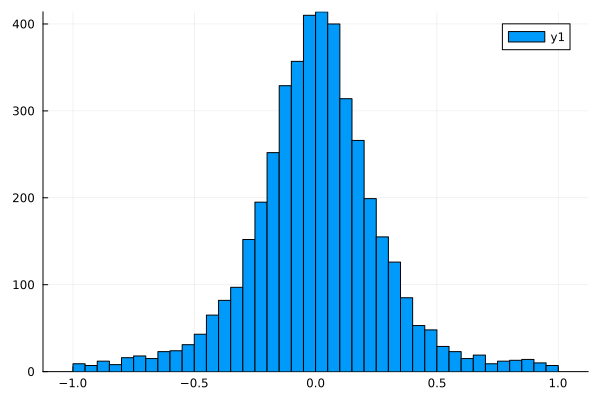

In [38]:
histogram(vec(y))

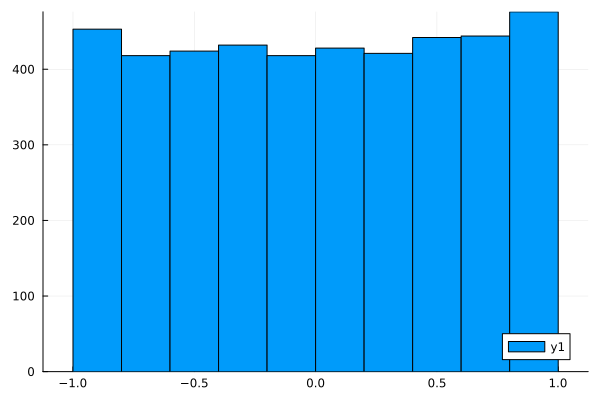

In [39]:
histogram(vec(yu))

In [40]:
ps_g = gdev(ps)
st_g = gdev(st)
ps_gu = gdev(ps_nb)
x_in_g = gdev(x_in);

In [41]:
y_g, _ = layer(x_in_g, ps_g, st_g)

(Float32[0.31375197 0.18704134 … 0.24516799 0.35924202; -0.046223085 0.088617176 … -0.27460155 -0.20809269; … ; 0.037995387 0.31661502 … -0.001690233 -0.08883502; -0.28843153 -0.15649094 … 0.3513329 0.18412179;;;; -0.119375974 0.033172194 … 0.24112388 -0.12388992; 0.37832937 0.1514404 … -0.1427318 0.18361506; … ; 0.05622817 -0.097877346 … -0.44700444 0.041512538; -0.04802501 0.25883156 … 0.3146255 0.053686175;;;; 0.060926776 -0.14038427 … -0.02993282 -0.016993314; -0.194889 -0.08126304 … 0.06554269 -0.11631095; … ; 0.33584392 -0.17153606 … -0.21859016 0.3226235; 0.033751745 -0.044332746 … -0.40022296 -0.115981415;;;; 0.099235386 0.036326203 … -0.10031547 0.16520125; 0.12706997 0.1998926 … 0.122834824 -0.17459978; … ; 0.099733576 -0.11491492 … -0.3729199 0.19190894; 0.024222417 -0.054468907 … 0.06605049 -0.05497999], (layer_1 = (layer = NamedTuple(), bias = NamedTuple()),))

In [42]:
y_gu, _ = layer(x_in_g, ps_gu, st_g)

(Float32[0.47253406 0.4473863 … 0.7161352 0.6574896; -0.32317647 0.19665524 … -0.41654545 -0.510309; … ; 0.42582837 0.9411228 … -0.9988688 -0.7846126; -0.49936816 -0.35935098 … 0.6615846 0.48517308;;;; -0.6728 0.21825725 … 0.79128546 -0.21357982; 0.5620864 0.27661255 … -0.813992 0.8345393; … ; 0.4807864 -0.6680157 … -0.9624865 0.103386454; -0.73535365 0.8892448 … 0.44456443 0.097698234;;;; 0.1250779 -0.6922086 … -0.0637203 -0.037600424; -0.39358985 -0.2769894 … 0.16543804 -0.32069078; … ; 0.5775584 -0.33841512 … -0.3452873 0.73823446; 0.06052988 -0.082255274 … -0.5549437 -0.2701575;;;; 0.24351126 0.16518591 … -0.20521168 0.72855455; 0.27988544 0.8801125 … 0.21350624 -0.3430063; … ; 0.63306314 -0.30915645 … -0.78401184 0.45601234; 0.060306683 -0.108913034 … 0.25984588 -0.095898785], (layer_1 = (layer = NamedTuple(), bias = NamedTuple()),))

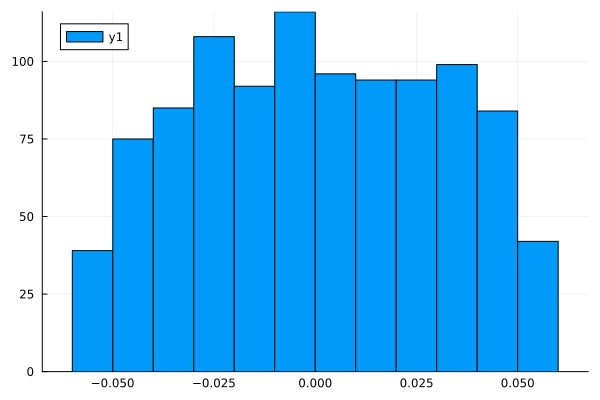

In [43]:
histogram(vec(ps.layer_1.layer.weight))

In [44]:
y2 = y_g |> cdev
y2u = y_gu |> cdev

33×33×1×4 Array{Float32, 4}:
[:, :, 1, 1] =
  0.472534    0.447386   -0.188178   -0.252063   …   0.716135    0.65749
 -0.323176    0.196655   -0.538826   -0.967329      -0.416545   -0.510309
 -0.146236   -0.0573618   0.802382   -0.943987      -0.464778    0.284104
  0.965215    0.10563     0.498074    0.951331      -0.215228    0.0134027
 -0.76802    -0.0224768   0.975626    0.0881356      0.97436    -0.613463
  0.2911     -0.707195   -0.794561    0.752553   …   0.883632   -0.926221
  0.212804   -0.055335   -0.517447    0.970728       0.769427   -0.768205
  0.692138   -0.658127   -0.591102    0.183867      -0.817439    0.152979
 -0.224187    0.72329    -0.091545   -0.437565      -0.182174    0.0237506
  0.602837   -0.0181743   0.0399734  -0.666457       0.853571    0.840782
  0.506441    0.203803    0.581694   -0.392436   …   0.580904    0.189107
 -0.492349    0.802203   -0.62629     0.979333       0.687313    0.833655
 -0.317763   -0.433715    0.342218    0.427925      -0.569145   -0.

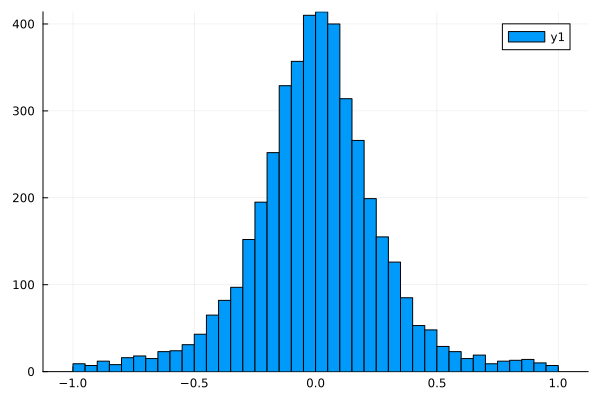

In [45]:
histogram(vec(y2))

In [46]:
# check cpu-gpu deviation

In [47]:
maximum(abs.(y .- y2))

2.66321f-5

In [48]:
maximum(abs.(yu .- y2u))

5.404818695153857e-6

# Dynamic

In [49]:
st_x = phase_to_train(x_in, spk_args=spk_args, repeats=10)

Spike Train: (64, 64, 1, 4) with 163840 spikes.

In [50]:
st_xg = SpikeTrainGPU(st_x)

SpikeTrainGPU{4}(CartesianIndex{4}[CartesianIndex(1, 1, 1, 1), CartesianIndex(2, 1, 1, 1), CartesianIndex(3, 1, 1, 1), CartesianIndex(4, 1, 1, 1), CartesianIndex(5, 1, 1, 1), CartesianIndex(6, 1, 1, 1), CartesianIndex(7, 1, 1, 1), CartesianIndex(8, 1, 1, 1), CartesianIndex(9, 1, 1, 1), CartesianIndex(10, 1, 1, 1)  …  CartesianIndex(55, 64, 1, 4), CartesianIndex(56, 64, 1, 4), CartesianIndex(57, 64, 1, 4), CartesianIndex(58, 64, 1, 4), CartesianIndex(59, 64, 1, 4), CartesianIndex(60, 64, 1, 4), CartesianIndex(61, 64, 1, 4), CartesianIndex(62, 64, 1, 4), CartesianIndex(63, 64, 1, 4), CartesianIndex(64, 64, 1, 4)], [1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  16375, 16376, 16377, 16378, 16379, 16380, 16381, 16382, 16383, 16384], Float32[0.8694714, 0.55315757, 0.42788148, 0.82462597, 0.7546664, 0.3145318, 0.5507898, 0.91853243, 0.20307493, 0.7325069  …  9.006453, 9.026997, 9.716133, 9.292594, 9.364104, 9.2278385, 9.210063, 9.63701, 9.3214, 9.190492], (64, 64, 1, 4), 16384, 0.0f0)

In [51]:
y_t, _ = layer(SpikingCall(st_x, spk_args, (0.0, 10.0)), ps, st)

(SpikingCall(Spike Train: (33, 33, 1, 4) with 43558 spikes., Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 0.001 (V)
, (0.0f0, 10.0f0)), (layer_1 = (layer = NamedTuple(), bias = NamedTuple()),))

In [52]:
y_sol, _ = sol_layer(SpikingCall(st_x, spk_args, (0.0, 10.0)), ps, st)

((Array{ComplexF32, 4}[[0.0f0 + 0.0f0im 0.0f0 + 0.0f0im … 0.0f0 + 0.0f0im 0.0f0 + 0.0f0im; 0.0f0 + 0.0f0im 0.0f0 + 0.0f0im … 0.0f0 + 0.0f0im 0.0f0 + 0.0f0im; … ; 0.0f0 + 0.0f0im 0.0f0 + 0.0f0im … 0.0f0 + 0.0f0im 0.0f0 + 0.0f0im; 0.0f0 + 0.0f0im 0.0f0 + 0.0f0im … 0.0f0 + 0.0f0im 0.0f0 + 0.0f0im;;;; 0.0f0 + 0.0f0im 0.0f0 + 0.0f0im … 0.0f0 + 0.0f0im 0.0f0 + 0.0f0im; 0.0f0 + 0.0f0im 0.0f0 + 0.0f0im … 0.0f0 + 0.0f0im 0.0f0 + 0.0f0im; … ; 0.0f0 + 0.0f0im 0.0f0 + 0.0f0im … 0.0f0 + 0.0f0im 0.0f0 + 0.0f0im; 0.0f0 + 0.0f0im 0.0f0 + 0.0f0im … 0.0f0 + 0.0f0im 0.0f0 + 0.0f0im;;;; 0.0f0 + 0.0f0im 0.0f0 + 0.0f0im … 0.0f0 + 0.0f0im 0.0f0 + 0.0f0im; 0.0f0 + 0.0f0im 0.0f0 + 0.0f0im … 0.0f0 + 0.0f0im 0.0f0 + 0.0f0im; … ; 0.0f0 + 0.0f0im 0.0f0 + 0.0f0im … 0.0f0 + 0.0f0im 0.0f0 + 0.0f0im; 0.0f0 + 0.0f0im 0.0f0 + 0.0f0im … 0.0f0 + 0.0f0im 0.0f0 + 0.0f0im;;;; 0.0f0 + 0.0f0im 0.0f0 + 0.0f0im … 0.0f0 + 0.0f0im 0.0f0 + 0.0f0im; 0.0f0 + 0.0f0im 0.0f0 + 0.0f0im … 0.0f0 + 0.0f0im 0.0f0 + 0.0f0im; … ; 0.0f0 + 0.0f0

In [53]:
y_tu, _ = layer(SpikingCall(st_x, spk_args, (0.0, 10.0)), ps_nb, st);

In [54]:
u = y_sol[1] |> stack;

In [55]:
size(u)

(33, 33, 1, 4, 1001)

In [56]:
uref = phase_to_potential.(0.0f0, y_sol[2], offset=0.0, spk_args=spk_args);

In [57]:
size(uref)

(1001,)

In [58]:
size(u)

(33, 33, 1, 4, 1001)

In [60]:
u_p = potential_to_phase(u, tbase, spk_args=spk_args) |> stack;

In [61]:
size(u_p)

(33, 33, 1, 4, 1001)

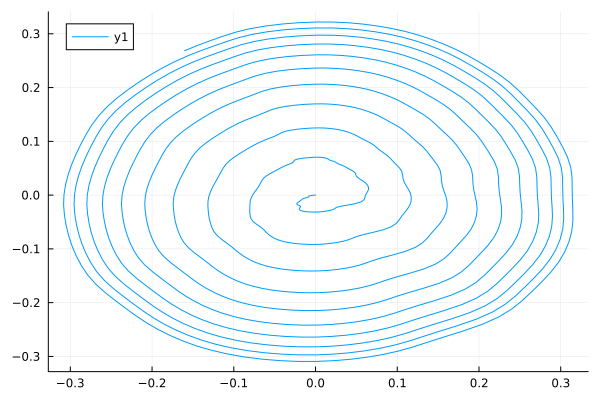

In [62]:
plot(real.(u[1,1,1,1,:]), imag.(u[1,1,1,1,:]))

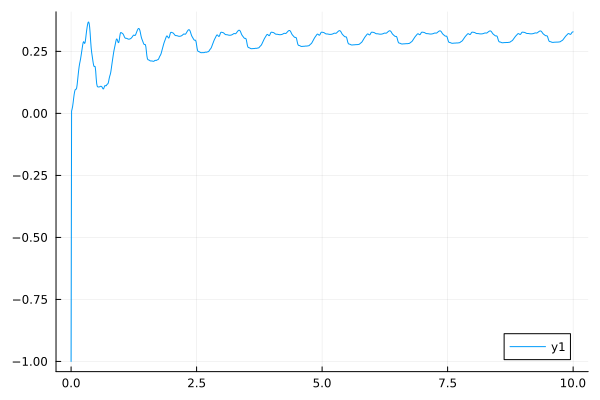

In [63]:
plot(tbase, u_p[1,1,1,1,:])

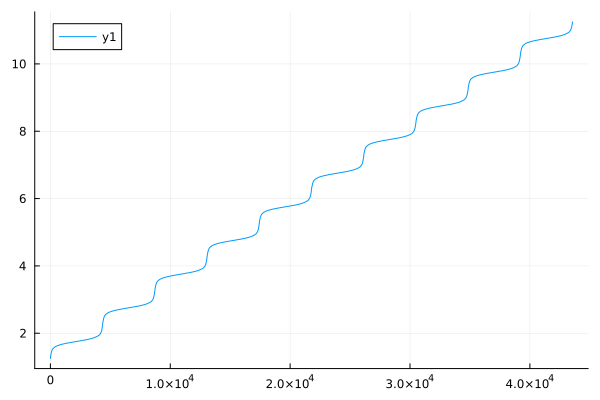

In [64]:
plot(sort(y_t.train.times))

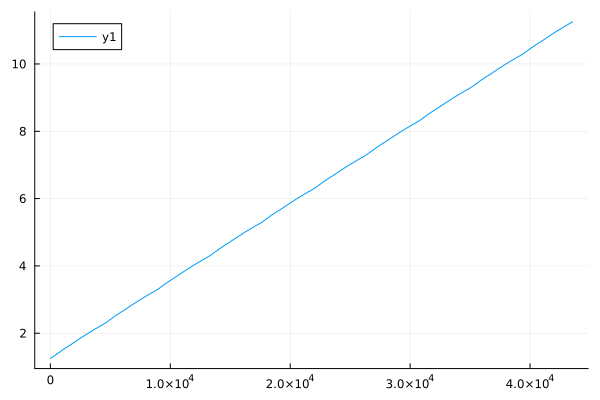

In [65]:
plot(sort(y_tu.train.times))

In [66]:
y_tp = train_to_phase(y_t);

In [67]:
y_tpu = train_to_phase(y_tu);

In [68]:
spk_args.spk_scale

1.0f0

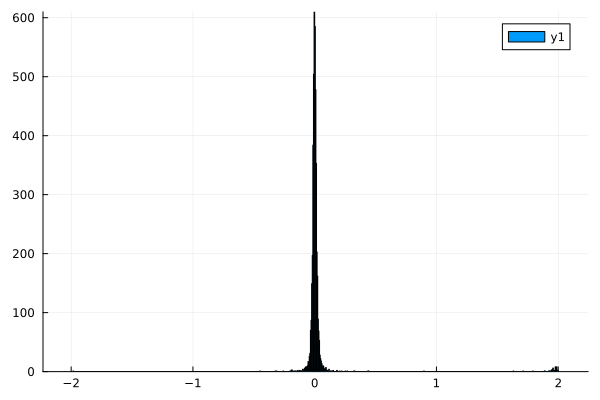

In [69]:
histogram(vec(y_tpu[5,:,:,:,:] .- yu))

In [70]:
y_tg, _ = layer(SpikingCall(st_xg, spk_args, (0.0, 10.0)), ps_g, st_g)

┌ Warning: Mixed Precision Inputs received for GPU convolution [weight: Float32] and [x: Float64]. Promoting to Float64.
└ @ LuxLib.Utils ~/.julia/packages/LuxLib/R8Czx/src/utils.jl:224


(SpikingCall(SpikeTrainGPU{4}(CartesianIndex{4}[CartesianIndex(1, 1, 1, 1), CartesianIndex(2, 1, 1, 1), CartesianIndex(3, 1, 1, 1), CartesianIndex(4, 1, 1, 1), CartesianIndex(5, 1, 1, 1), CartesianIndex(6, 1, 1, 1), CartesianIndex(7, 1, 1, 1), CartesianIndex(8, 1, 1, 1), CartesianIndex(9, 1, 1, 1), CartesianIndex(10, 1, 1, 1)  …  CartesianIndex(24, 33, 1, 4), CartesianIndex(25, 33, 1, 4), CartesianIndex(26, 33, 1, 4), CartesianIndex(27, 33, 1, 4), CartesianIndex(28, 33, 1, 4), CartesianIndex(29, 33, 1, 4), CartesianIndex(30, 33, 1, 4), CartesianIndex(31, 33, 1, 4), CartesianIndex(32, 33, 1, 4), CartesianIndex(33, 33, 1, 4)], [1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  4347, 4348, 4349, 4350, 4351, 4352, 4353, 4354, 4355, 4356], Float32[1.912734, 1.7300417, 1.7412122, 1.7639513, 1.6538172, 1.8150756, 1.7854167, 1.9270033, 1.6915569, 1.907221  …  10.41239, 10.930175, 10.790582, 10.72332, 10.848647, 10.630583, 10.750034, 10.811659, 10.848594, 10.721077], (33, 33, 1, 4), 4356, 0.25f0), Neuron param

In [71]:
y_tgu, _ = layer(SpikingCall(st_xg, spk_args, (0.0, 10.0)), ps_gu, st);

In [72]:
y_tpg = train_to_phase(y_tg);

In [73]:
y_tpgu = train_to_phase(y_tgu);

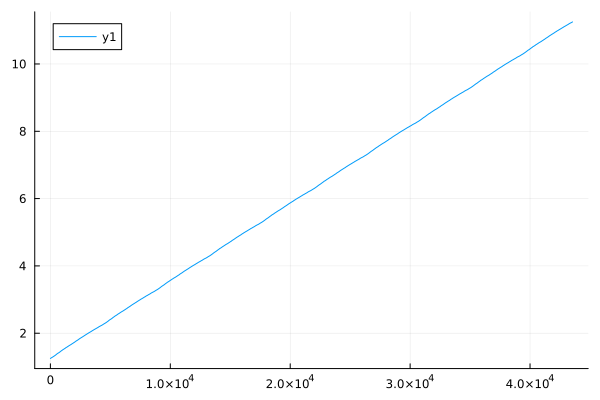

In [74]:
plot(sort(y_tgu.train.times |> cdev))

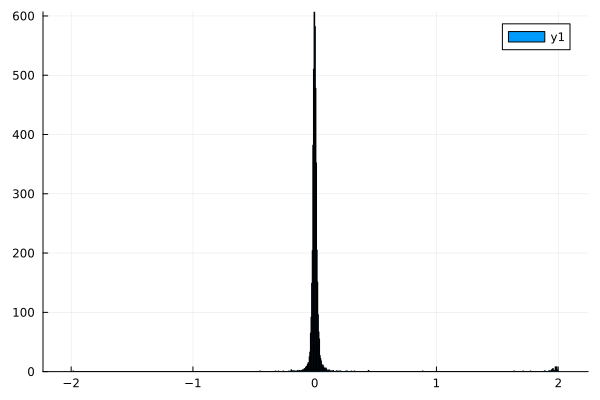

In [75]:
histogram(vec(y_tpgu[5,:,:,:,:] .- yu))

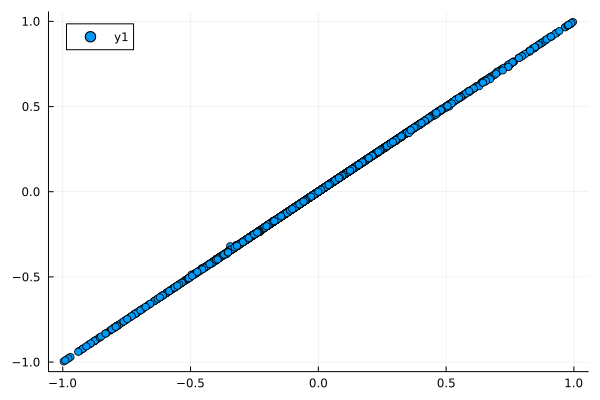

In [76]:
scatter(vec(y_tp[4,:,:,:,:]), vec(y_tpg[4,:,:,:,:]))

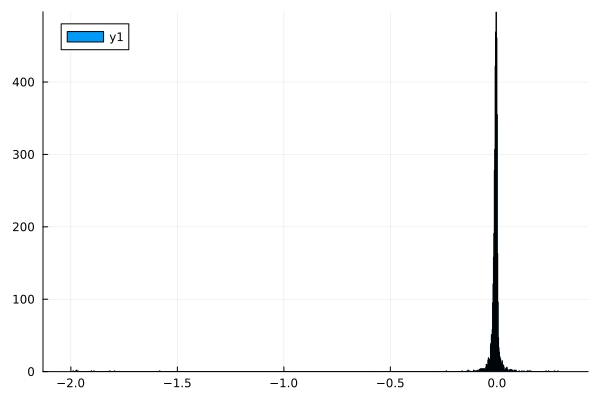

In [80]:
histogram(vec(y .- y_tpg[8,:,:,:,:]))

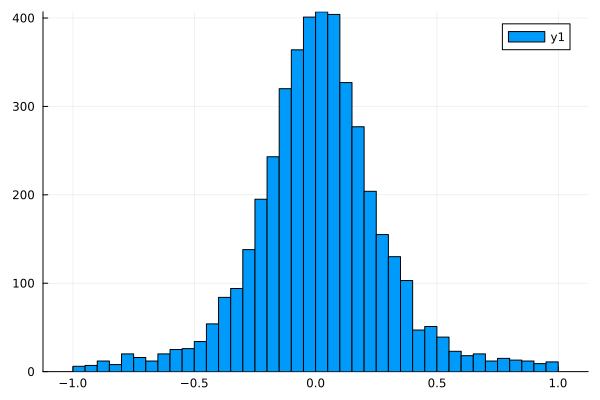

In [81]:
histogram(y_tpg[8,:,:,:,:] |> vec)

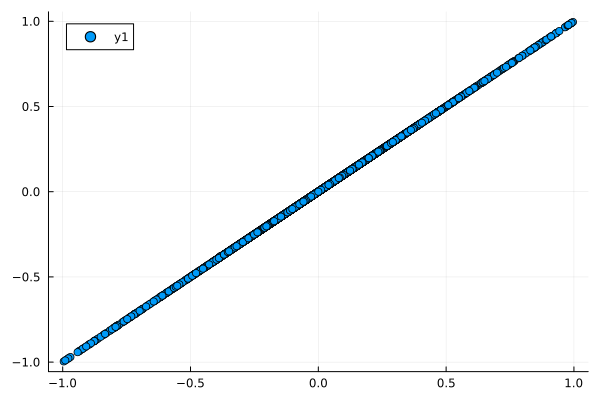

In [82]:
scatter(vec(y_tp[8,:,:,:,:]), vec(y_tpg[8,:,:,:,:]))

In [84]:
size(y)

(33, 33, 1, 4)

In [85]:
size(y_tp)

(10, 33, 33, 1, 4)

In [90]:
size(y_tpg)

(11, 33, 33, 1, 4)

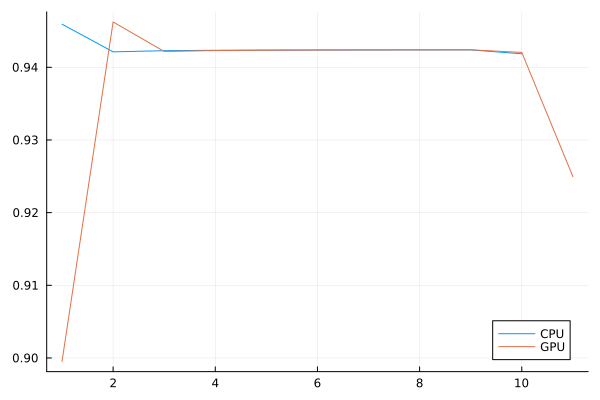

In [91]:
plot(cycle_correlation(reshape(y, 33^2,4), reshape(y_tp, (10,33^2,4))), label = "CPU")
plot!(cycle_correlation(reshape(y, 33^2,4), reshape(y_tpg, (11,33^2,4))), label="GPU")